In [1]:
import numpy as np
import os, sys
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import neuroglancer
from PIL import Image
from scipy.ndimage import zoom

In [2]:
animal = 'DK55'
ROOT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'

boundary_tiff_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'boundaries.tiff')
boundary_np_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'zoomed_sagittal_boundary.npy')
#volume = io.imread(boundary_tiff_path)
volume = np.load(boundary_np_path)
#downsampled_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'downsampled.tiff')
#downsampled_stack = io.imread(downsampled_path)

#atlas_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'registered_atlas_original_orientation.tiff')
#atlas_stack = io.imread(atlas_path)
print(volume.shape, volume.dtype)

(1546, 2359, 485) uint8


In [4]:
fpath = os.path.join(ROOT, animal,  'preps/CH1/thumbnail_aligned')
files = os.listdir(fpath)
z = len(files)
midfile = str(z // 2).zfill(3) + ".tif"
midfilepath = os.path.join(ROOT, animal,  f'preps/CH1/thumbnail_aligned/{midfile}')
mid_arr = io.imread(midfilepath)
print(midfile,mid_arr.shape, z) 

242.tif (1546, 2359) 485


In [5]:
print(volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

(981, 643, 388) int8 0 1 0.028194029377756995


uint8 (1546, 2359)


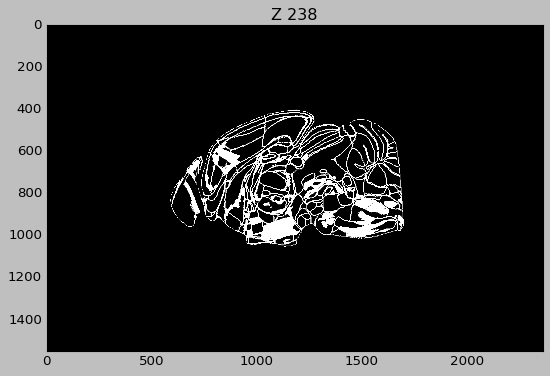

uint8 (1546, 2359)


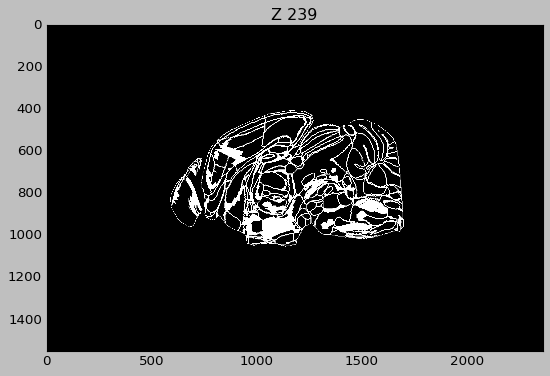

uint8 (1546, 2359)


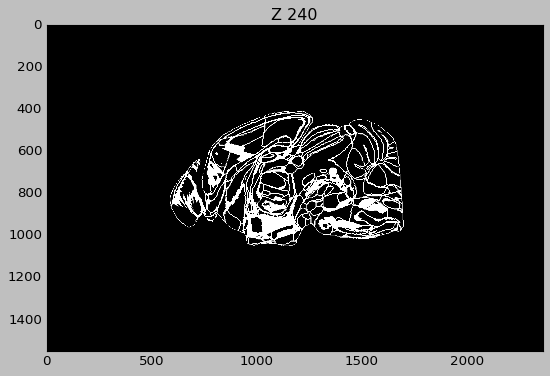

uint8 (1546, 2359)


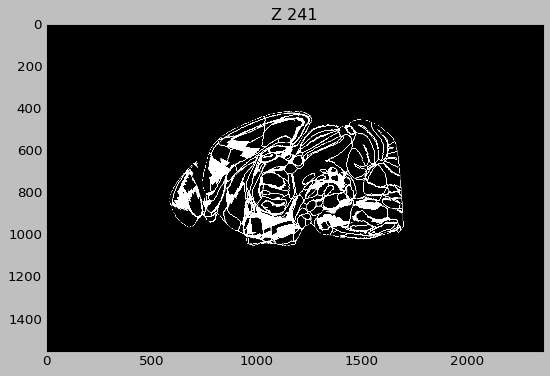

uint8 (1546, 2359)


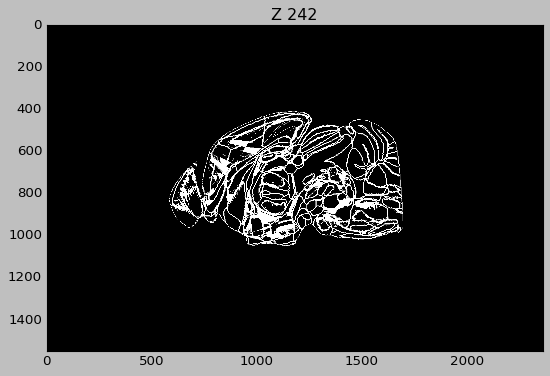

uint8 (1546, 2359)


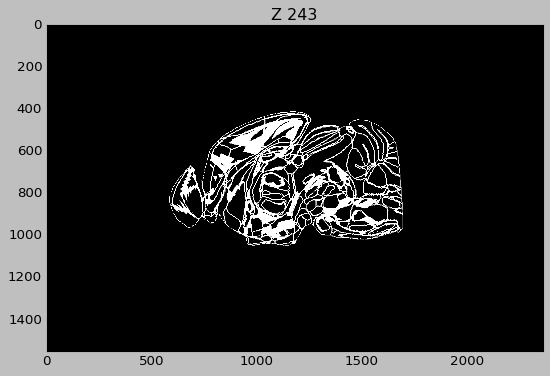

uint8 (1546, 2359)


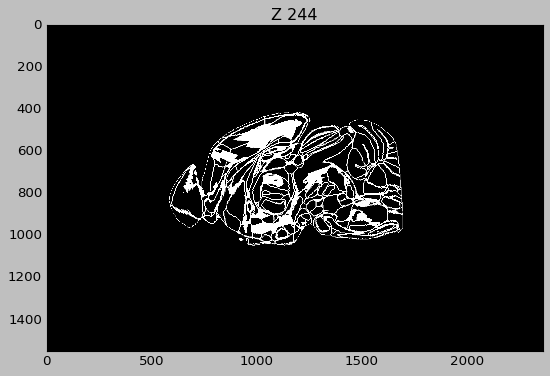

uint8 (1546, 2359)


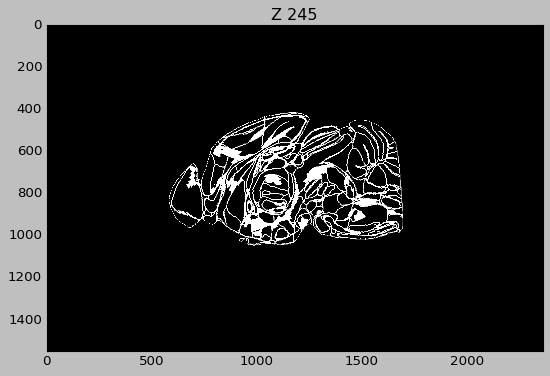

In [6]:
#arr = np.rot90(arr, 3)
midsection = volume.shape[2] // 2 
n = 4
start = midsection - n
end = midsection + n
plt.style.use('classic')
for i in range(start, end,1):
    img = volume[:,:,i]
    img[img > 0] = 255
    print(img.dtype, img.shape)
    #img = np.rot90(img, 3)
    #img = np.flip(img, axis=1)
    plt.title('Z {}'.format(i))
    plt.imshow(img, cmap="gray")
    plt.show()

In [7]:
boundary_outpath = os.path.join(ROOT, animal, 'preps/CH1/boundary')
os.makedirs(boundary_outpath, exist_ok=True)
arr = volume.copy()
endsection = arr.shape[2]   
for i in tqdm(range(0, endsection, 1)):
    img = arr[:,:,i]
    img[img > 0] = 255
    f = str(i).zfill(3) + '.tif'
    outpath = os.path.join(boundary_outpath, f)
    cv2.imwrite(outpath, img)
    


(643, 981, 388) uint8


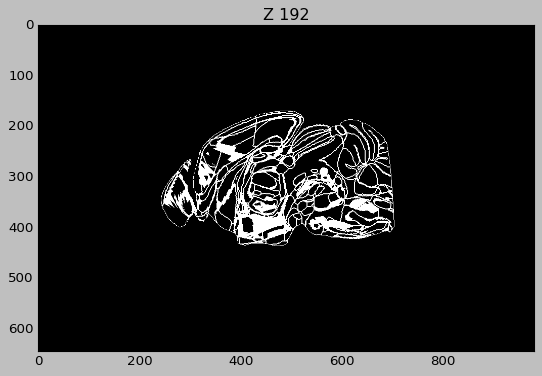

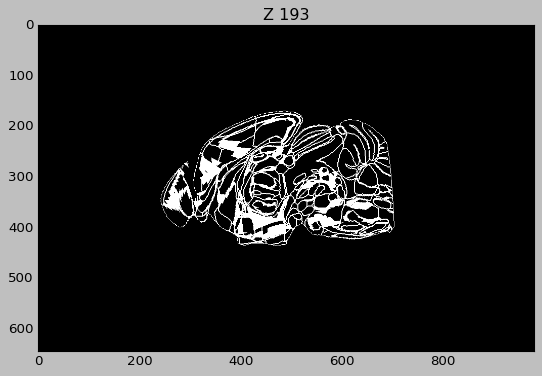

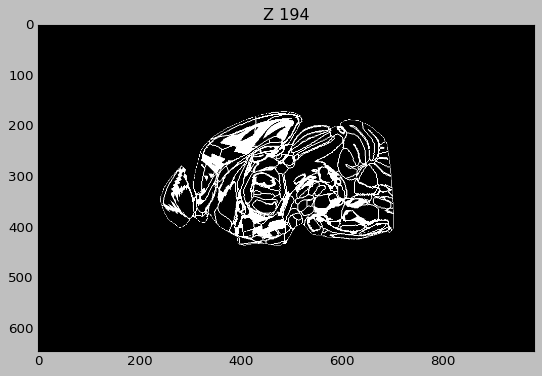

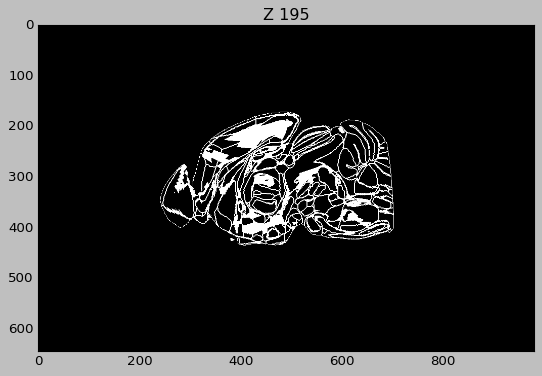

In [6]:
sagittal_arr = sagittal_arr.astype(np.uint8)
print(sagittal_arr.shape, sagittal_arr.dtype)
midsection = sagittal_arr.shape[2] // 2 
n = 2
start = midsection - n
end = midsection + n
plt.style.use('classic')
for i in range(start, end,1):
    img = sagittal_arr[:,:,i]
    plt.title('Z {}'.format(i))
    plt.imshow(img, cmap="gray")
    plt.show()

In [7]:
sagittal_np_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'sagittal_boundary')
np.save(sagittal_np_path, sagittal_arr)

In [8]:
change_y = mid_arr.shape[0] / sagittal_arr.shape[0]
change_x = mid_arr.shape[1] / sagittal_arr.shape[1]
change_z = z / sagittal_arr.shape[2]
print(change_y, change_x, change_z)

2.404354587869362 2.4046890927624873 1.25


In [15]:
zatlas = zoom(sagittal_arr, (change_y, change_x, change_z))
print('zatlas',zatlas.shape)
print('volume', mid_arr.shape, z)

: 

: 

In [19]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[10.4, 10.4, 20])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=volume,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol invlerp normalized

void main() {
    float pix =  normalized();
  	  emitGrayscale(pix) ;
}
""")
print(viewer)

http://127.0.0.1:43601/v/878a282262c3cfcfbf0bc353b8f02e3b92f5c0c8/


In [17]:
OUTPATH = os.path.join(HOME, 'work','tifs')
arr = volume.copy()
arr = np.rot90(arr, 3)
start = 0
end = arr.shape[2]
for i in range(start, end,1):
    outfile = str(i).zfill(3) + '.tif'
    outpath = os.path.join(OUTPATH, outfile)
    cv2.imwrite(outpath, arr[:,:,i])